In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
sys.path.append('../')

In [3]:
import argparse
import json
import os
import sys
from pathlib import Path

import numpy as np
import torch

# from models.common import DetectMultiBackend
# from utils.callbacks import Callbacks
# from utils.dataloaders import create_dataloader
# from utils.general import (LOGGER, Profile, check_dataset, check_img_size, check_requirements, check_yaml,
#                            coco80_to_coco91_class, colorstr, increment_path, non_max_suppression, print_args,
#                            scale_boxes, xywh2xyxy, xyxy2xywh)
# from utils.metrics import ConfusionMatrix, ap_per_class, box_iou
# from utils.plots import output_to_target, plot_images, plot_val_study
# from utils.torch_utils import select_device, smart_inference_mode

/Users/louislacombe/opt/anaconda3/envs/yolov5_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ROOT = "/Users/louislacombe/Thesis_code/yolov5/"
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative


LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
WORLD_SIZE = int(os.getenv('WORLD_SIZE', 1))

In [49]:
import yaml
import datetime
from tqdm import tqdm

from utils.general import split_dict

from utils.calibration import (setup_data_model, get_yolo_predictions, get_data_pred, calib_prep, collect_data_obj, fitting_obj_calibrators, predict_obj_conf, draw_reliability_graph)

from sklearn.isotonic import IsotonicRegression

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
opt = '../config/opt/opt_Visdrone_detect_S_Hyp0.yaml'
dataloader, model, opt, device, dt = setup_data_model(opt, ROOT)

YOLOv5 🚀 v6.2-190-gbdcfaf3 Python-3.10.6 torch-1.12.1 CPU

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/Users/louislacombe/Thesis_code/datasets/VisDrone/VisDrone2019-DET-test-dev/labels.cache' images and labels... 1610 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]


In [8]:
data_dict = get_yolo_predictions(dataloader, model, opt, device, dt)

                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 51/51 [10:14<00:00, 12.04s/it]


In [9]:
calib_dict, test_dict = split_dict(data_dict, (0.3, 0.7))
print("Length calib dict: ", len(calib_dict), " and length calib dict: ", len(test_dict))

Length calib dict:  15  and length calib dict:  36


In [10]:
# Calibration parameters:
n_bins = 50
conf_thres = opt.conf_thres
iou_thres_obj = 0.6
iou_thres_class = 0.6

# On which data should you apply the calibration
where_apply_calib="pred"

# Choose which calibrator you want to use for the calibration
# calibrator = HistogramBinning(n_bins) # Histogram binning
# calibrator = _SigmoidCalibration() # Platt
calibrator = IsotonicRegression(out_of_bounds="clip") # Isotonic Regression


In [33]:
print("Calibration preperation")
calib_prep(
    calib_dict,
    where_apply_calib=where_apply_calib,
    num_classes=model.model.nc,
    device=device,
    conf_thres=conf_thres,
    iou_thres_obj=iou_thres_obj,
    iou_thres_class=iou_thres_class,
    obj_calib=True,
    class_calib=False
)

calib_prep(
    test_dict,
    where_apply_calib=where_apply_calib,
    num_classes=model.model.nc,
    device=device,
    conf_thres=conf_thres,
    iou_thres_obj=iou_thres_obj,
    iou_thres_class=iou_thres_class,
    obj_calib=True,
    class_calib=False
)

print("Putting all values together")
obj_y_pred_CALIB, obj_y_true_CALIB = collect_data_obj(calib_dict, where_apply_calib=where_apply_calib)
    
print("Calibrate")
fitted_calibrator = fitting_obj_calibrators(obj_y_true_CALIB, obj_y_pred_CALIB, calibrator)

print("Predicting the objectness values")
pred_obj_calib = predict_obj_conf(test_dict, fitted_calibrator, where_apply_calib=where_apply_calib)

Calibration preperation


100%|██████████| 36/36 [00:00<00:00, 56.58it/s]

Putting all values together
Calibrate
Predicting the objectness values


In [71]:
from utils.general import scale_boxes, non_max_suppression

def create_pred_for_nms(values_, name_preds):
    """
    Re-creating the predictions using the calibrated values.

    Parameters
    ----------
    path : _type_
        The path to the image that you want to create the NMS preciction.
    chosen_dict : _type_
        Dictionnary where you can find the values for the bbox and class.
    chosen_dict_obj : _type_
        Dictionnary where you can find the calibrated values for objectness.
    bbox_name : _type_
        Name of the variable for which you should look for bbox coordinate values. 
    obj_name : _type_
        Name of the variable for which you should look for objectness confidence values. 
    class_name : _type_
        Name of the variable for which you should look for class confidence values. 

    Returns
    ------
    _type_
        The tensor prediction object for this image path.
    """
    bbox_ = torch.tensor(values_[name_preds[0]][values_["idx"]], device=device)
    obj_ = torch.tensor(values_[name_preds[1]].reshape(-1, 1), device=device)
    class_ = torch.tensor(values_[name_preds[2]][values_["idx"]], device=device)
    
    pred_ = torch.cat((bbox_, obj_, class_), dim=1)
    pred_ = torch.reshape(pred_, [1, pred_.shape[0], pred_.shape[1]])
    return pred_

def NMS(dataloader, dict_, name_preds, save_after_nms, num_classes):
    """
    Create the tensor and pass the tensor through the NMS

    Parameters
    ----------
    dataloader : _type_
        The dataloader from loading all the pictures.
    chosen_dict : _type_
        Dictionnary where you can find the values for the bbox and class.
    chosen_dict_obj : _type_
        Dictionnary where you can find the calibrated values for objectness.
    before_nms : list, optional
        List with the names of the variables for which you should look for coordinates of the bbox, the objectness and class confidence values, by default ["pred_bbox", "calib_obj_conf", "pred_class_conf"]
    save_after_nms : str, optional
        The name of the saved variables in the dictionnary, by default "after_nms_calib"
    """
    for (im, targets, path, shapes) in tqdm(dataloader):
        path = path[0]
        if path in dict_:
            if device.type != 'cpu':
                im = im.to(device, non_blocking=True)
                targets = targets.to(device)
            im = im.half() if opt.half else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            nb, _, height, width = im.shape  # batch size, channels, height, width

            pred_ = create_pred_for_nms(dict_[path], name_preds)

            preds_nms_ = non_max_suppression(
                pred_,
                opt.conf_thres,
                opt.iou_thres,
                labels=[],
                multi_label=opt.multi_label_nms,
                agnostic=opt.agnostic_nms,
                max_det=opt.max_det,
                output_confs=True
            )

            # Statistics per image
            for si, pred_nms_ in enumerate(preds_nms_):
                scale_boxes(im[si].shape[1:], pred_nms_[:, :4], shapes[si][0], shapes[si][1])  # native-space pred

            get_data_pred(preds_nms_[0], dict_, path, save_after_nms, num_classes)


In [73]:
# Applying NMS with the calibrated objectness values
name_preds = ["pred_bbox_xywh", "pred_calib_obj_score", "pred_class_score"]
NMS(dataloader, test_dict, name_preds=name_preds, save_after_nms="after_nms_calib", num_classes=model.model.nc)

100%|██████████| 51/51 [00:07<00:00,  7.09it/s]


In [ ]:
# Running NMS on the calibrated objects to use as train set for classes
pred_obj_calib = predict_obj_conf(calib_dict, fitted_calibrator, where_apply_calib=where_apply_calib)
NMS(dataloader, calib_dict, save_after_nms="after_nms_calib")

In [ ]:
calib_prep(calib_dict, calib_dict_obj, calib_dict_class, conf_thres, iou_thres_class, obj_calib=False, class_calib=True, where_apply="after_nms_calib")
calib_prep(test_dict, test_dict_obj, test_dict_class, conf_thres, iou_thres_class, obj_calib=False, class_calib=True, where_apply="after_nms_calib")

list_y_true_calib, list_y_pred_calib = collect_data_class(calib_dict_obj, calib_dict_class)
calibrators_fitted = fitting_class_calibrators(list_y_true_calib, list_y_pred_calib, calibrator, perc=0.6)

list_y_calibrated = predict_class_conf(test_dict_obj, test_dict_class, calibrators_fitted)

In [12]:
obj_true = []
obj_normal = []
obj_calib = []

for item in test_dict:
    obj_true.extend(test_dict[item]["pred_obj_y_true"])
    obj_calib.extend(test_dict[item]["pred_calib_obj_score"])
    idx = test_dict[item]["idx"]
    obj_normal.extend(test_dict[item]["pred_obj_score"][idx])



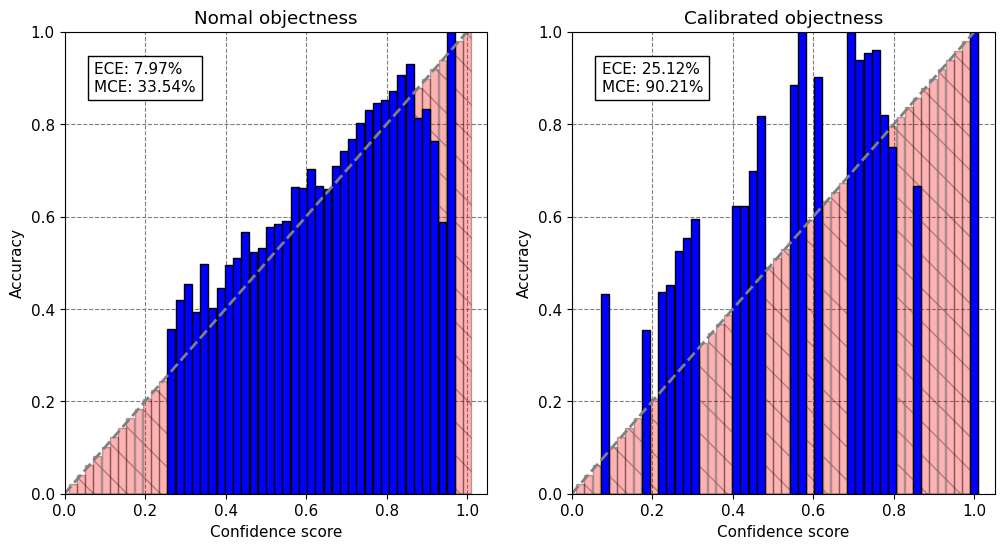

In [13]:
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(12, 6))
draw_reliability_graph(np.array(obj_normal), np.array(obj_true), n_bins, strategy="uniform", title="Nomal objectness", axs=axs1)
draw_reliability_graph(np.array(obj_calib), np.array(obj_true), n_bins, strategy="uniform", title="Calibrated objectness", axs=axs2)
plt.show()

In [14]:
# Configure
model.eval()
iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
niou = iouv.numel()

seen = 0
confusion_matrix = ConfusionMatrix(nc=nc)
if isinstance(names, (list, tuple)):  # old format
    names = dict(enumerate(names))
class_map = list(range(1000))
s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
tp, fp, p, r, f1, mp, mr, map50, ap50, map = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
jdict, stats, ap, ap_class = [], [], [], []


NameError: name 'ConfusionMatrix' is not defined